# $\mathbf{LOG}$ $\mathbf{ERROR}$ $\mathbf{ANALYSIS}$ $\mathbf{OF}$ $\mathbf{PROPERTY}$ $\mathbf{VALUE}$ $\mathbf{ESTIMATES}$
##  Analysis of Zestimate 'Logerror' of 2017 Single Family Home Transactions
### Prepared for Zillow Data Science Team
$\rightarrow$Report and Presentation by Ryan Miller, Staff Data Scientist | 6/20/2022

----

# $\bigstar$ Executive Summary

### Problem: Zillow needs to better understand the driver's behind its current model's log error measurement - that is the difference between the natural log of a property's 'Zestimate' and the natural log of the actual selling price.
### Actions: Examined 2017 actual selling price data ('tax assessed value') for 3 Southern California counties, along with features collected by Zillow and the log error from Zillow's Zestimate (the Target variable).  Used clustering technique to dive deeper into feature relationships and create new ones. Then built numerous log error prediction models based on these features, testing the best one on the dataset to see if it can beat baseline.
### Conclusions:  Initial clustering efforts provided no major illiuminations on the drivers of logerror, nor created any useful features or groupings of continuous variables that improved the model much compared to existing features.  Overall though, a ~10% improvement over baseline logerror was modeled.
### Recommendations: Instead of predicting effects on logerror, the analysis should go back to focusing on improving overall model accuracy (reducing RMSE around sales price - aka taxvaluedollaramt).  For next steps I would continue to look for useful clustering.

# $\bigstar$ Libraries Used

Common DS Libraries:

In [1]:
# For data analysis:
import numpy as np
import pandas as pd

# Graphs/Visualizations:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# For Statistics and Hypothesis Testing:
import scipy.stats as stats

# For Modeling:
from itertools import combinations
from sklearn.cluster import KMeans
from sklearn.feature_selection import SelectKBest, f_regression, RFE, RFECV
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler

Internally Created Helper Functions:

In [2]:
# For acquiring the dataset(note - your credentials will work if stored in an env.py file):
from acquire import get_zillow_data

# For preparing and cleaning as well as splitting and encoding the dataset
# and splitting into new df, X_train_exp, X_train, y_train, X_validate, y_validate, X_test, y_test:
import wrangle

# For running bivariate and multivariate graphical comparisons
import explore

# For evaluating regression models
import evaluate

# For comparing regression model outcomes
import model_comparator

Others:

In [3]:
#Ignore Warnings:
import warnings
warnings.filterwarnings('ignore')

# reloads import files each time a cell is ran
%load_ext autoreload
%autoreload 2

# $\bigstar$ Data Acquisition and Summary Analysis

## Database examination and SQL query based on new goals

For this analysis, I brought in the entire feature set from the Zillow (aka Codeup) database for all Single Family Residential Properties (code 261), along with the logerror and transaction date.

In [4]:
# Acquires and caches zillow data, and displays key variable information
df_raw = get_zillow_data()
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52442 entries, 0 to 52441
Data columns (total 64 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      52442 non-null  int64  
 1   id                            52442 non-null  int64  
 2   logerror                      52442 non-null  float64
 3   transactiondate               52442 non-null  object 
 4   id.1                          52442 non-null  int64  
 5   airconditioningtypeid         13638 non-null  float64
 6   architecturalstyletypeid      70 non-null     float64
 7   basementsqft                  47 non-null     float64
 8   bathroomcnt                   52442 non-null  float64
 9   bedroomcnt                    52442 non-null  float64
 10  buildingclasstypeid           0 non-null      float64
 11  buildingqualitytypeid         33741 non-null  float64
 12  calculatedbathnbr             52305 non-null  float64
 13  d

## Clean up features and remove nulls

My initial steps were to examine to data and prep and clean, first removing nulls and clearly unimportant/duplicate features.  After this I ran a distribution analysis on the dataset to further refine by removing outliers and additional unimportant/duplicate features.

### *Cleaning Step 1:  I noticed there were duplicate parcel ids when properties were sold multiple times in a year., so removed duplicate parcelids keeping the most recent one (last transaction). Then drop parcelid since it is no longer needed for analysis (can be added back in with predictions).*

In [5]:
# To remove these duplicates, I sort values by date and then keep the last transaction
df = df_raw.sort_values('transactiondate').drop_duplicates(subset='parcelid', keep = 'last')

### *Cleaning Step 2: There are 33 columns missing more than 25% of their inputs (all are missing at least 35%).  We will drop all of these.*

In [6]:
# The following function identifies the number and percentage of nulls per column
column_nulls = explore.column_null_analyzer(df_raw)
column_nulls[column_nulls['pct_rows_missing']>.25]

,num_rows_missing,pct_rows_missing
,,
finishedsquarefeet15,52442,1.000000
buildingclasstypeid,52442,1.000000
finishedsquarefeet13,52442,1.000000
storytypeid,52395,0.999104
basementsqft,52395,0.999104
yardbuildingsqft26,52379,0.998799
architecturalstyletypeid,52372,0.998665
typeconstructiontypeid,52366,0.998551
fireplaceflag,52361,0.998455


In [7]:
# In addition, I identified the following columns to remove
columns_to_remove = [
    'id.1', # different values but redundant with id
    'transactiondate.1', # same as transactiondate
    'logerror.1', # same as logerror
    'propertylandusetypeid', # same for all properties: 261
    'censustractandblock', # same as rawcensustractandblock, except 10**6 higher
    'finishedsquarefeet12', # same as calculatedfinsihedsquarefeet but with 247 less rows
    'regionidcounty', # same as fips - found in distribution analysis
    'roomcnt', # too many zeros - found in distribution analysis
    'assessmentyear', # All 2016
    'regionidzip', # Inaacurate (all zips in Oregon, not SoCal)
    'rawcensustractandblock', # unhelpful - discovered in distribution analysis
    'bathroomcnt', # redundant with calculatedbathnbr
    'fullbathcnt', # redundant with calculatedbathnbr
    'id', # not impactful
    'parcelid'] # No longer needed

### *Cleaning Step 3: While removing columns with 25% or more null values, I also removed rows with more than 25% of their values missing.*

In [8]:
# This calls a functions which removes above indicated columns, as well as columns or rows with 25%+ nulls.
df = wrangle.data_prep(df,cols_to_remove = columns_to_remove)

Features removed: 
['parcelid', 'id', 'id.1', 'airconditioningtypeid', 'architecturalstyletypeid', 'basementsqft', 'bathroomcnt', 'buildingclasstypeid', 'buildingqualitytypeid', 'decktypeid', 'finishedfloor1squarefeet', 'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet50', 'finishedsquarefeet6', 'fireplacecnt', 'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa', 'heatingorsystemtypeid', 'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'propertylandusetypeid', 'propertyzoningdesc', 'rawcensustractandblock', 'regionidcounty', 'regionidneighborhood', 'regionidzip', 'roomcnt', 'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid', 'unitcnt', 'yardbuildingsqft17', 'yardbuildingsqft26', 'numberofstories', 'fireplaceflag', 'assessmentyear', 'taxdelinquencyflag', 'taxdelinquencyyear', 'censustractandblock', 'logerror.1', 'transactiondate.1']


### *Cleaning Step 4: Rename features to simplify, to include counties; convert to integers where possible; add in an absolute logerror measurement and drop logerror since we are focused solely on magnitude*

In [9]:
# Renames columns for easier analysis
df = df.rename(columns={'bathroomcnt':'bathrooms','bedroomcnt':'bedrooms','calculatedfinishedsquarefeet':'sqft','fips':'county','fullbathcnt':'fullbaths','lotsizesquarefeet':'lotsize','regionidcity':'citycode','propertycountylandusecode':'landusecode','structuretaxvaluedollarcnt':'structurevalue','taxvaluedollarcnt':'salesvalue','landtaxvaluedollarcnt':'landvalue'})

# Renames fips with their county name
df['county'] = np.where(df.county == 6037, 'Los Angeles', np.where(df.county == 6059, 'Orange','Ventura') )

# Changes types, to include floats to ints where possible
df = df.astype({'sqft':'int', 'bedrooms':'int', 'lotsize':'int', 'yearbuilt':'int','structurevalue':'int','citycode':'object','salesvalue':'int','landvalue':'int','taxamount':'int'})
# Creates a logerror magnitude column, and drops the original logerror
df['abs_logerror'] = abs(df.logerror)
df = df.drop(columns = 'logerror')

With all nulls and initial columns removed and renamed, I will now move to univariate exploration to further examine the dataset.

## Univariate Exploration

Running univariate distribution analysis on all numeric columns with the exception of citycode (quasi-categorical)

bedrooms


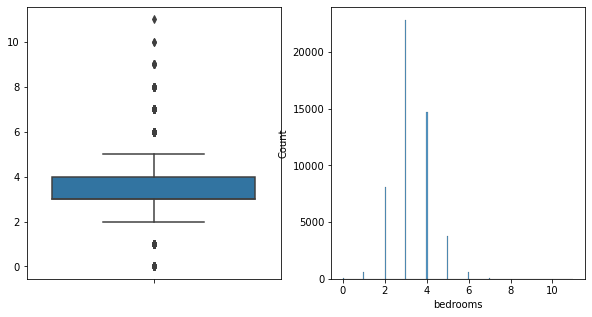

3     22835
4     14713
2      8107
5      3764
6       604
1       560
7       100
0        28
8        23
9         8
10        2
11        1
Name: bedrooms, dtype: int64

-----

calculatedbathnbr


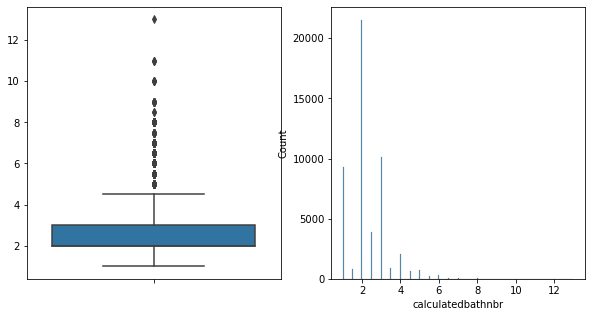

2.0     21520
3.0     10149
1.0      9320
2.5      3865
4.0      2070
3.5       884
1.5       815
5.0       741
4.5       659
6.0       283
5.5       221
7.0        85
8.0        49
6.5        45
7.5        16
9.0        12
10.0        5
11.0        3
8.5         2
13.0        1
Name: calculatedbathnbr, dtype: int64

-----

sqft


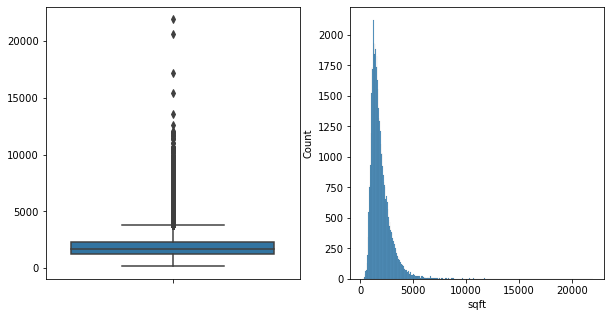

1120    128
1200    114
1080     99
936      85
1176     83
       ... 
3888      1
7300      1
6596      1
4400      1
5655      1
Name: sqft, Length: 4661, dtype: int64

-----

latitude


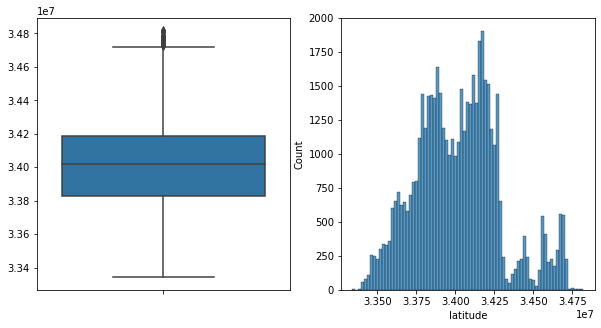

34487900.0    7
34101300.0    7
34041200.0    6
33765800.0    5
33865295.0    4
             ..
34225336.0    1
33980050.0    1
33626793.0    1
34039761.0    1
34010864.0    1
Name: latitude, Length: 49044, dtype: int64

-----

longitude


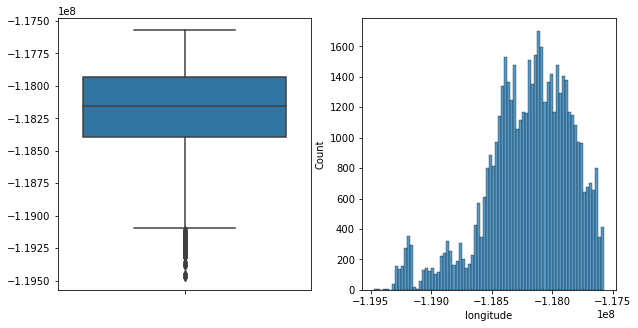

-117835000.0    7
-118327000.0    7
-118172000.0    7
-118251000.0    6
-118364216.0    5
               ..
-118065312.0    1
-118038472.0    1
-118420379.0    1
-117694443.0    1
-117900894.0    1
Name: longitude, Length: 49311, dtype: int64

-----

lotsize


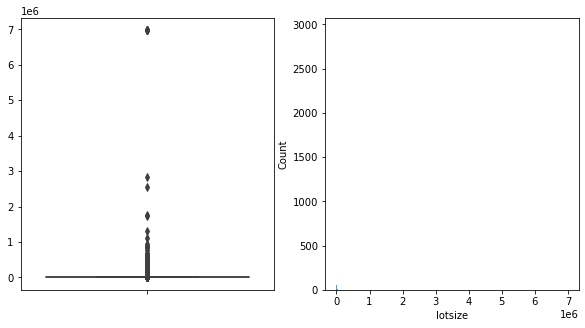

6000     866
5000     406
7200     296
7000     280
6500     270
        ... 
12255      1
13569      1
66814      1
16140      1
47405      1
Name: lotsize, Length: 14014, dtype: int64

-----

yearbuilt


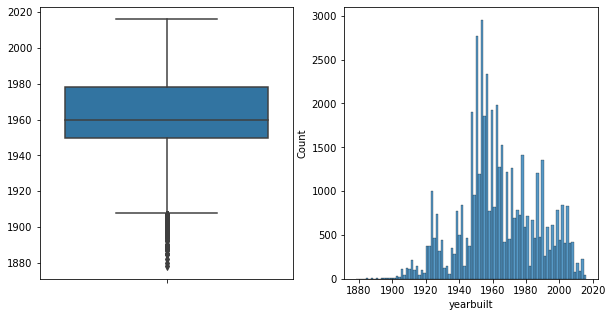

1955    1855
1950    1590
1954    1487
1953    1466
1956    1348
        ... 
1892       1
1878       1
1882       1
1894       1
1880       1
Name: yearbuilt, Length: 133, dtype: int64

-----

structurevalue


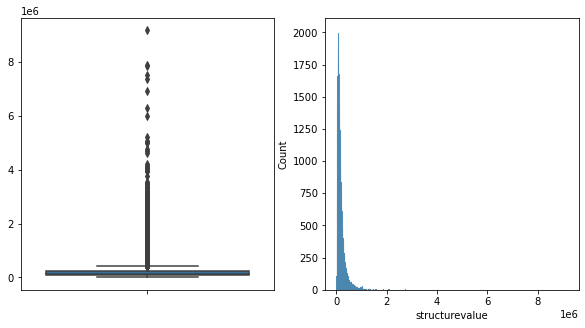

100000    48
200000    36
90000     32
32489     27
95000     26
          ..
195541     1
462589     1
271084     1
47943      1
77118      1
Name: structurevalue, Length: 36320, dtype: int64

-----

salesvalue


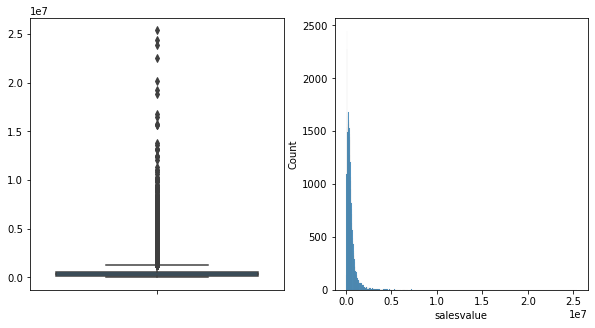

455000    31
600000    29
500000    24
450000    24
550000    22
          ..
26246      1
190846     1
117177     1
172093     1
259334     1
Name: salesvalue, Length: 37933, dtype: int64

-----

landvalue


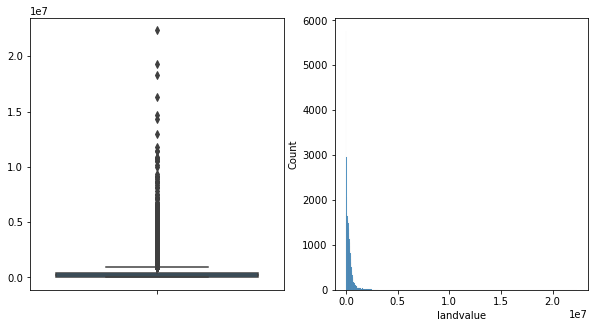

21299      94
22755      63
30210      62
16522      53
16749      51
           ..
137218      1
1012305     1
637120      1
95490       1
283704      1
Name: landvalue, Length: 35924, dtype: int64

-----

taxamount


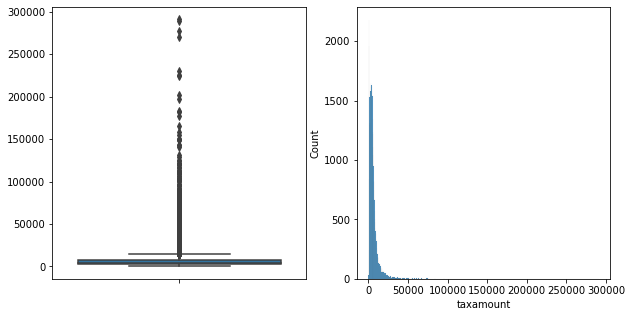

3287     20
1170     19
999      18
1066     16
1301     16
         ..
9754      1
18757     1
13438     1
568       1
18655     1
Name: taxamount, Length: 14828, dtype: int64

-----

abs_logerror


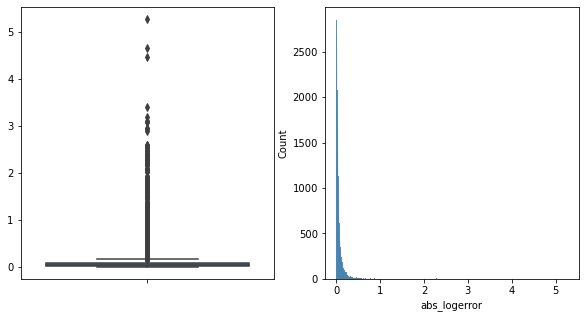

0.001878    5
0.000727    5
0.000231    5
0.002652    5
0.008257    4
           ..
0.065963    1
0.140079    1
0.074333    1
0.024347    1
0.197755    1
Name: abs_logerror, Length: 50502, dtype: int64

-----



In [10]:
# Show all numerical univariate distributions along with value counts
explore.univariate_distributions(df)

Also running a histgram on the sales date feature:

<function matplotlib.pyplot.show(close=None, block=None)>

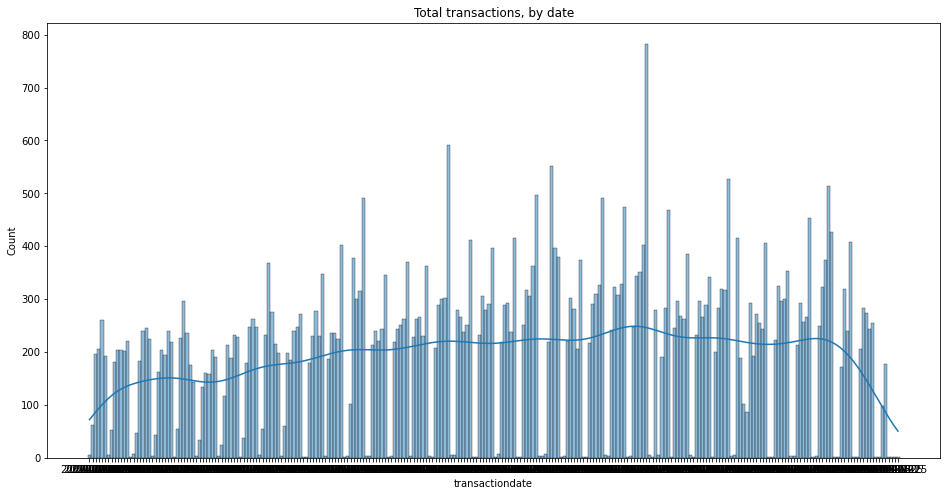

In [11]:
# Plots the count of sales per date, along with a kde
plt.figure(figsize = (16,8))
plt.title('Total transactions, by date')
sns.histplot(df['transactiondate'],kde=True)
plt.show

### *Cleaning Step 5: Remove Outliers*

Using a k of 2 (meaning accounts for outliers 2x IQR above and below the 75% and 25% quantiles respectively.

In [12]:
# The following function looks for and removes outliers from all columns not removed from outlier consideration for various reasons
outlier_columns_to_remove = ['abs_logerror','transactiondate','county','latitude','landusecode','longitude','citycode']
wrangle.outlier_destroyer(df,2, cols_to_remove = outlier_columns_to_remove) 
df.describe()

,bedrooms,calculatedbathnbr,sqft,latitude,longitude,lotsize,yearbuilt,structurevalue,salesvalue,landvalue,taxamount,abs_logerror
count,50745.000000,50745.000000,50745.000000,5.074500e+04,5.074500e+04,5.074500e+04,50745.000000,5.074500e+04,5.074500e+04,5.074500e+04,50745.000000,50745.000000
mean,3.302040,2.291270,1910.561770,3.402071e+07,-1.181942e+08,1.109001e+04,1962.999704,1.932756e+05,5.227851e+05,3.295095e+05,6355.125096,0.072200
std,0.929058,1.005137,990.252191,2.719820e+05,3.560590e+05,8.730506e+04,22.820452,2.507078e+05,7.129264e+05,5.202534e+05,8261.361352,0.161280
min,0.000000,1.000000,152.000000,3.334085e+07,-1.194754e+08,2.360000e+02,1878.000000,1.480000e+02,3.254000e+03,1.610000e+02,49.000000,0.000002
25%,3.000000,2.000000,1266.000000,3.382720e+07,-1.183975e+08,5.573000e+03,1950.000000,7.674800e+04,1.920950e+05,7.431300e+04,2638.000000,0.014139
50%,3.000000,2.000000,1650.000000,3.402034e+07,-1.181524e+08,6.823000e+03,1960.000000,1.305350e+05,3.700000e+05,2.169140e+05,4601.000000,0.032840
75%,4.000000,3.000000,2286.000000,3.418502e+07,-1.179296e+08,8.750000e+03,1978.000000,2.215300e+05,6.120000e+05,4.072730e+05,7265.000000,0.070584
max,11.000000,13.000000,21929.000000,3.481877e+07,-1.175723e+08,6.971010e+06,2016.000000,9.164901e+06,2.538125e+07,2.233550e+07,290998.000000,5.262999


### Cleaning Step 6: Extras to Cut

There were two datapoints for the channel islands, which are enough of an outlier in general to remove:

In [13]:
# Find the two properties in the channel islands where longitude is most negative = most western
df[df.longitude.isin(df.longitude.nsmallest(2))]

,transactiondate,bedrooms,calculatedbathnbr,sqft,county,latitude,longitude,lotsize,landusecode,citycode,yearbuilt,structurevalue,salesvalue,landvalue,taxamount,abs_logerror
4294,2017-01-30,4,3.0,1908,Ventura,34373735.0,-119475265.0,8767,1110,34543.0,1959,109725,245552,135827,7705,1.897475
12465,2017-03-20,3,2.0,1686,Ventura,34374072.0,-119475416.0,5813,1110,34543.0,1952,57271,1075583,1018312,16350,0.156173


In [14]:
# Drop outlier longitudes by index 
df.drop(labels=[4294,12465], axis=0,inplace = True)
df[df.longitude.isin(df.longitude.nsmallest(2))]

,transactiondate,bedrooms,calculatedbathnbr,sqft,county,latitude,longitude,lotsize,landusecode,citycode,yearbuilt,structurevalue,salesvalue,landvalue,taxamount,abs_logerror
1968,2017-01-13,1,1.5,1232,Ventura,34365242.0,-119447944.0,2588,1110,34543.0,1978,70639,82209,11570,856,0.027171
42166,2017-07-28,3,1.5,1698,Ventura,34365693.0,-119448392.0,2588,1110,34543.0,1979,193413,286606,93193,2987,0.071886


## Questions/Hypothesis

1. Is there some more granular geographic way to determine logerror?
2. Does structure value contribute to logerror 
3. Does landusecode have any impact on logerror? 
4. Does transaction date have any impact on logerror?
5. Are there any clusters of value?

## Feature Engineering

1. The first feature was absolute logerror, which was previously added to the dataframe.
2. The next feature, structure value/sales value, captures any diffrences between structure and land values for total sales value.
3. Finally, I decided to replace regionidcity (with 175 categorical entries) and then refined cluster based on average sales price within that cluster.

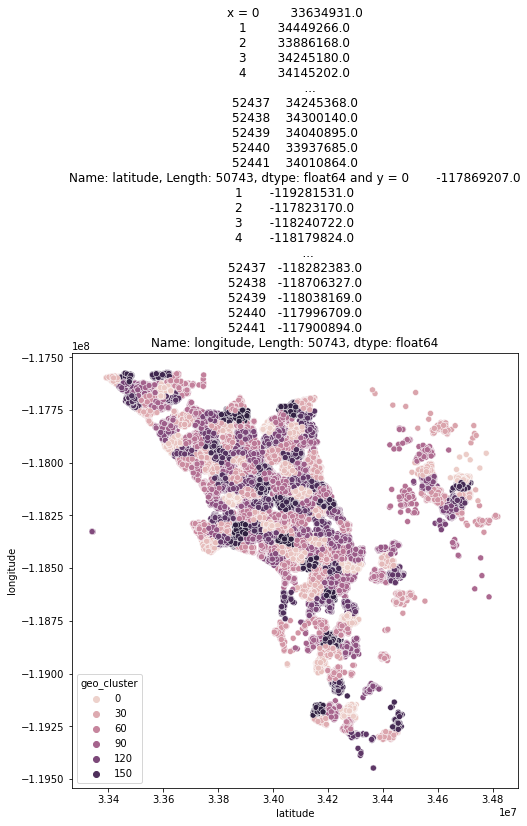

In [15]:
# Create 175 clusters (equal to count of regionidcity) by lat and long
kmeans = KMeans(n_clusters = 175)
kmeans.fit(df[['latitude','longitude']])
df['geo_cluster'] = kmeans.predict(df[['latitude','longitude']])
plt.figure(figsize = (8,8))
plt.title(f'x = {df.latitude} and y = {df.longitude}')
sns.scatterplot(data = df, x = df.latitude, y = df.longitude, hue='geo_cluster')
plt.show()

# $\bigstar$ Exploratory Data Analysis

## Seperating into actionable datasets:
1. df : adds dummy variables to original categorical variables for county and landusecode
2. X_train_exp : train split of df above, with original categoricals but without feature (abs_logerror)
3. X_train : train, split and fully encoded w/o target
4. y_train : target (logerror) from train
5. X-validate, y_validate, X_test, y_test: seperated like X_train and y_train

In [16]:
# Splits into EDA and modeling dataframes
df, X_train_exp, X_train, y_train, X_validate, y_validate, X_test, y_test = wrangle.full_wrangle(df_raw)

Features removed: 
['parcelid', 'id', 'id.1', 'airconditioningtypeid', 'architecturalstyletypeid', 'basementsqft', 'bathroomcnt', 'buildingclasstypeid', 'buildingqualitytypeid', 'decktypeid', 'finishedfloor1squarefeet', 'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet50', 'finishedsquarefeet6', 'fireplacecnt', 'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa', 'heatingorsystemtypeid', 'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'propertylandusetypeid', 'propertyzoningdesc', 'rawcensustractandblock', 'regionidcity', 'regionidcounty', 'regionidneighborhood', 'regionidzip', 'roomcnt', 'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid', 'unitcnt', 'yardbuildingsqft17', 'yardbuildingsqft26', 'numberofstories', 'fireplaceflag', 'assessmentyear', 'taxdelinquencyflag', 'taxdelinquencyyear', 'censustractandblock', 'logerror.1', 'transactiondate.1']

-----
Columns reduced by 30 to 34, and rows red

### I plotted all numerical features against one another to determine any colinear relationships.

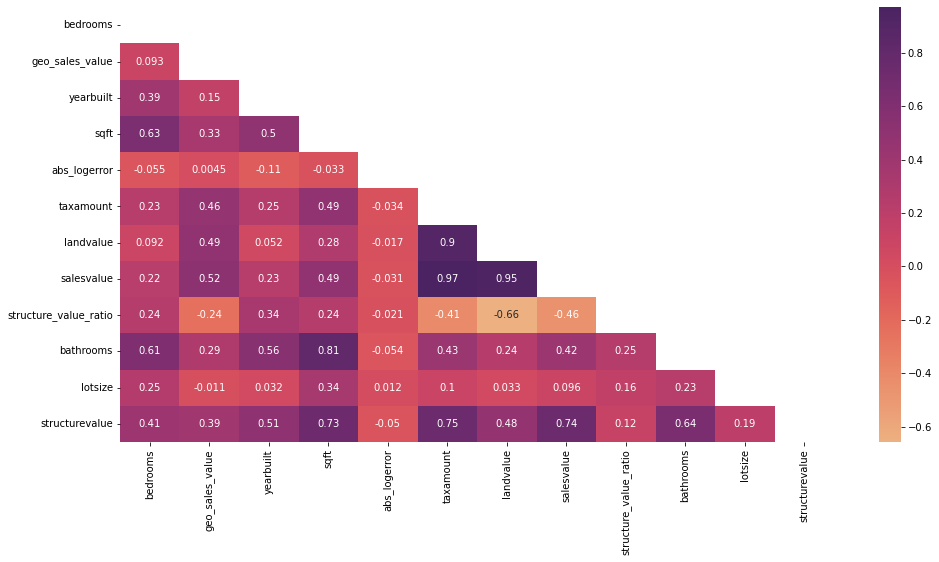

In [17]:
# Identify columns to compare - removing unhelpful and encoded features
num_cols = [col for col in df.columns if df[col].dtype != 'object']
features_to_remove = [
 'latitude',
 'longitude',  
 'county_Los Angeles',
 'county_Orange',
 'county_Ventura',
 'landusecode_0100',
 'landusecode_0101',
 'landusecode_0102',
 'landusecode_0103',
 'landusecode_0104',
 'landusecode_0108',
 'landusecode_0109',
 'landusecode_010G',
 'landusecode_010M',
 'landusecode_0131',
 'landusecode_1',
 'landusecode_1110',
 'landusecode_1111',
 'landusecode_122']
features = list(set(num_cols)-set(features_to_remove))
# Create a correlation matrix from the continuous numerical columns
df_num_cols = df[features]
corr = df_num_cols.corr()

# Pass correlation matrix on to sns heatmap
plt.figure(figsize=(16,8))
sns.heatmap(corr, annot=True, cmap="flare", mask=np.triu(corr))
plt.show()

>### *Key Takeaway - nothing much new here, other than noting there is a big negative correlation between structure value ratio and the value of the land it is on which is surprising and means land is probably more of a driver than the structure on top of it.*

### Next, I sought to answer questions around my initial hypothesis, and plotted all features against the target, performing statistical testing as well.

In [18]:
# Set our alpha (1 - confidence interval of .95)
alpha = .05

### *1. Is there some more granular geographic way to determine logerror?*

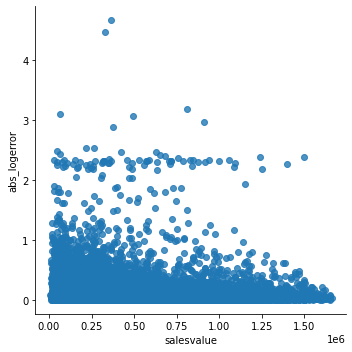

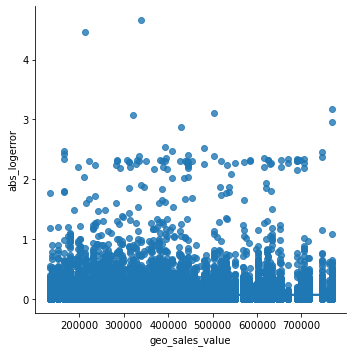

In [19]:
# lm plots of salesvalue vs. geo cluster feature of sales value
sns.lmplot(data = df, x='salesvalue', y='abs_logerror')
sns.lmplot(data = df, x='geo_sales_value', y='abs_logerror')
plt.show()

##### Comparing (Pearson's r correlation):

$H_{0}$ = Feature is not correlated with log error.

$H_{1}$ = Feature is correlated with log error.

In [20]:
# correlation test of salesvalue
corr, p = stats.pearsonr(df.salesvalue, df.abs_logerror)
print('corr: ',corr,'p: ',p)
print("is p/2 < alpha? ", p / 2 < alpha)

corr:  -0.0314698169663766 p:  1.9157889166979885e-11
is p/2 < alpha?  True


In [21]:
# correlation test of geo_sales_value
corr, p = stats.pearsonr(df.geo_sales_value, df.abs_logerror)
print('corr: ',corr,'p: ',p)
print("is p/2 < alpha? ", p / 2 < alpha)

corr:  0.004496507847079656 p:  0.33763818898839826
is p/2 < alpha?  False


>### *Key Takeaway - Interestingly, while sales price is correlated with log error, the feature composed of geographic clusters is not.*

### *2. Does structure value impact logerror (as opposed to total property value)?*

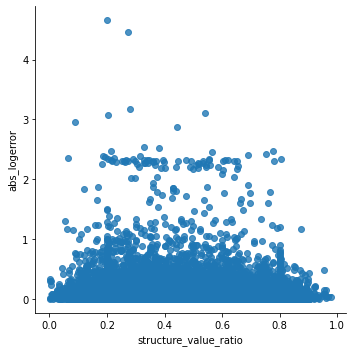

In [22]:
#lm plot showing feature engineered structure_value_ratio's correlation to abs_logerror
sns.lmplot(data = df, x='structure_value_ratio', y='abs_logerror')
plt.show()

##### Hypothesis Testing (Pearson's r correlation):

$H_{0}$ = Structure ratio value is not correlated with log error.

$H_{1}$ = Structure ration value is correlated with log error.

In [23]:
# correlation test of structure_value_ratio
corr, p = stats.pearsonr(df.structure_value_ratio, df.abs_logerror)
print('corr: ',corr,'p: ',p)
print("is p/2 < alpha? ", p / 2 < alpha)

corr:  -0.02077585193437084 p:  9.391431233997305e-06
is p/2 < alpha?  True


>### *Key Takeaway - Structure value ratio is correlated to abs_logerror, albeit weakly and negatively.*

### *3. Do landusecodes have any impact on logerror?*

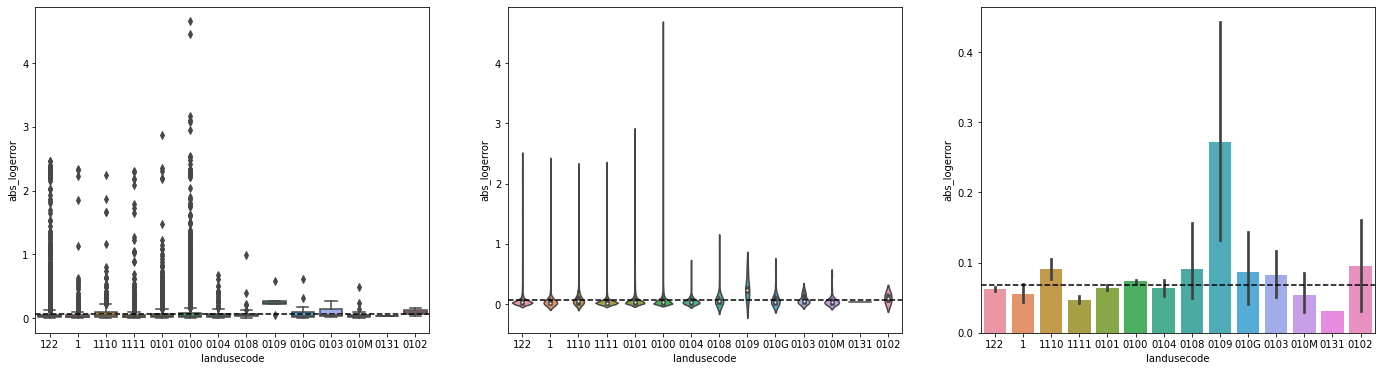

In [24]:
# graphic landusecodes as categorical
plt.figure(figsize = (24,6))
plt.subplot(1,3,1)
sns.boxplot(data = df, x='landusecode', y='abs_logerror')
plt.axhline(df['abs_logerror'].mean(), ls='--', color='black')
plt.subplot(1,3,2)
sns.violinplot(data = df, x='landusecode', y='abs_logerror')
plt.axhline(df['abs_logerror'].mean(), ls='--', color='black')
plt.subplot(1,3,3)
sns.barplot(data = df, x='landusecode', y='abs_logerror')
plt.axhline(df['abs_logerror'].mean(), ls='--', color='black')
plt.show()

In [25]:
# Checking on number of properties that are under use code 0109
df[df.landusecode == '0109'].shape

(5, 34)

##### Hypothesis Testing (ANOVA):

$H_{0}$ = The means for all landusecodes are the same.

$H_{1}$ = The means for all landusecodes are different.

Assumptions: (X)Independent | ( ) Normal (or 30+ obs) | (?) Equal variances?
The data is not normal nor has enough observations to satisfy the central limit theorem, but I will still go ahead and run it with a Kruskal-Wallis test.

In [26]:
stats.kruskal(df['landusecode_0100'],
 df['landusecode_0101'],
 df['landusecode_0102'],
 df['landusecode_0103'],
 df['landusecode_0104'],
 df['landusecode_0108'],
 df['landusecode_0109'],
 df['landusecode_010G'],
 df['landusecode_010M'],
 df['landusecode_0131'],
 df['landusecode_1'],
 df['landusecode_1110'],
 df['landusecode_1111'],
 df['landusecode_122'])

KruskalResult(statistic=203756.13909820668, pvalue=0.0)

##### With a p-value of nearly zero, we can reject the null hypothesis that all means are the same.

>### *Key Takeaway - Logerror is dominated by propeties with landusecode 0109 (propertycountylandusecode).  That said, it's not a signifigant part of the dataset, and since the means are different will include these as encoded variables when modeling.*

### *4. Does transaction date have any impact on logerror?*

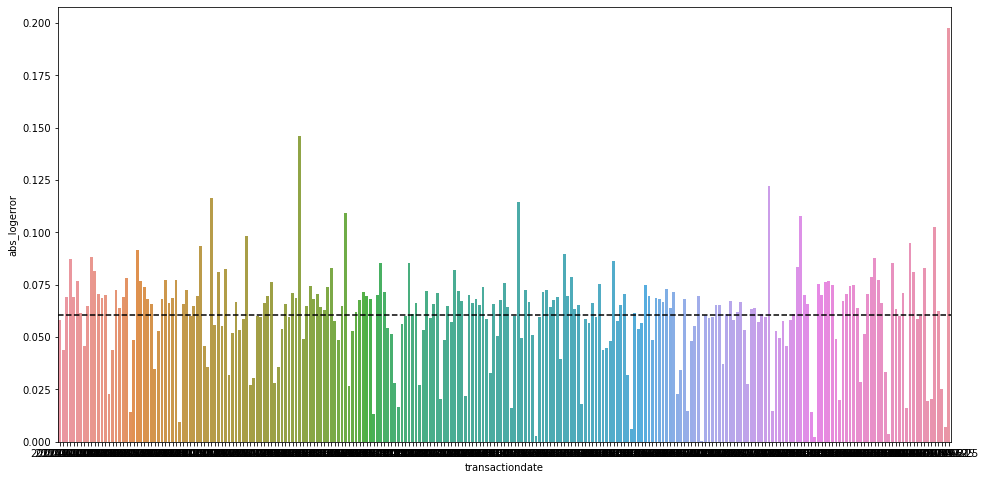

In [27]:
# Create a dataframe with target and feature variable of interest
date_a = df[['transactiondate','abs_logerror']]

# Group abs_logerror's mean, by date
date_a = pd.DataFrame(date_a.groupby('transactiondate').abs_logerror.mean())

#Plot mean abs logerror by date
plt.figure(figsize = (16,8))
sns.barplot(x = date_a.index, y = date_a.abs_logerror)
plt.axhline(date_a['abs_logerror'].mean(), ls='--', color='black')
plt.show()

>### *Key Takeaway - It appears to not have an impact.  Plus this is only a partial year, so because of that, it's generally uniform distribution, and the fact house sales are not typically single day events, I do not feel this is not a driver for logerror.*

## Clustering

I did robust cluster analysis in my workbook, comparing all features against one another, multiple k-values, both alone and with all the extra dimensions added in.  There were no obvious clusterings.  The only thing of potential use was the geographical clustering which did not give me anything of value.
Thus, I can drop lat and longitude data from my datasets going forward.

## EDA Outcomes:

1. Geographic clusters were not valuable, nor were any other clusters analyzed.  Thus, dropping geo_sales_value as well as latitude and longitude.
2. Land use code does not impact logerror.
3. Transaction date does not have any impact.
4. Structure value ratio may be a better predictor than other measures of property value.  Will investigate this in modedling.

In [28]:
# Modify the three feature sets to drop unnecessary features for further analysis
X_train = X_train.drop(columns = ['latitude','longitude','geo_sales_value'])
X_validate = X_validate.drop(columns = ['latitude','longitude','geo_sales_value'])
X_test = X_test.drop(columns = ['latitude','longitude','geo_sales_value'])

# $\bigstar$ Feature Selection

### After using RFE on all the features, I used RFECV to pick the best ones for modeling.

In [29]:
# Use sklearns rfecv feature to identify optimal feature set for modeling
lm = LinearRegression()
rfecv = RFECV(lm, min_features_to_select = 1)
rfecv.fit(X_train, y_train)
feature_mask = rfecv.support_
rfecv_features = X_train.iloc[:,feature_mask].columns.tolist()
rfecv_features

['sqft',
 'yearbuilt',
 'landvalue',
 'county_Los Angeles',
 'county_Ventura',
 'landusecode_0100',
 'landusecode_0101',
 'landusecode_0102',
 'landusecode_0103',
 'landusecode_0104',
 'landusecode_0108',
 'landusecode_0109',
 'landusecode_010G',
 'landusecode_010M',
 'landusecode_0131',
 'landusecode_1',
 'landusecode_1110',
 'landusecode_1111',
 'landusecode_122']

# $\bigstar$ Modeling

#### KEY METRIC: RMSE

Used Root Mean Square Error, as it gives us performance of the models in the difference from the actual unit's logerror.

#### BASELINE:

In [30]:
# Create a list to hold a future dataframe for display
model_comparator_list = []

# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# 1. Predict target_pred_mean
abs_logerror_pred_mean = y_train['abs_logerror'].mean()
y_train['abs_logerror_pred_mean'] = abs_logerror_pred_mean
y_validate['abs_logerror_pred_mean'] = abs_logerror_pred_mean

# 2. compute target_pred_median
abs_logerror_pred_median = y_train['abs_logerror'].median()
y_train['abs_logerror_pred_median'] = abs_logerror_pred_median
y_validate['abs_logerror_pred_median'] = abs_logerror_pred_median

# 3. RMSE of target_pred_mean
rmse_train_mean = mean_squared_error(y_train.abs_logerror, y_train.abs_logerror_pred_mean)**(1/2)
rmse_validate_mean = mean_squared_error(y_validate.abs_logerror, y_validate.abs_logerror_pred_mean)**(1/2)

# 4. RMSE of target_pred_median
rmse_train_median = mean_squared_error(y_train.abs_logerror, y_train.abs_logerror_pred_median)**(1/2)
rmse_validate_median = mean_squared_error(y_validate.abs_logerror, y_validate.abs_logerror_pred_median)**(1/2)

results = {'Model' : 'Baseline Median','RMSE Train':rmse_train_median,'RMSE Validate':rmse_validate_median}
model_comparator_list.append(results)
results = {'Model' : 'Baseline Mean','RMSE Train':rmse_train_mean,'RMSE Validate':rmse_validate_mean}
model_comparator_list.append(results)

pd.DataFrame(model_comparator_list).round(2).set_index('Model')

,RMSE Train,RMSE Validate
Model,,
Baseline Median,0.16,0.16
Baseline Mean,0.15,0.16


#### MODEL OUTCOME COMPARISON:

In [31]:
# Uses externally created function to generate dataframe
model_comparator.zillow_model_comparator(X_train,y_train,X_validate,y_validate,features= rfecv_features)

Model,Baseline Median,Baseline Mean,OLS,LassoLars,GLM,"Polynomial, Deg. 2","Polynomial, Deg. 3"
RMSE Train,0.1565,0.1520,0.1508,0.1520,0.1508,1.503000e-01,1.500000e-01
RMSE Validate,0.1609,0.1568,0.1559,0.1568,0.1558,7.463479e+10,3.590443e+10
Overfit %,2.8100,3.1600,3.3800,3.1600,3.3200,4.965721e+13,2.393628e+13


>### *GLM/Tweedie Regressor with Power = 1 and Alpha = 0 produces the Best Model*

## Test:

In [32]:
y_test = pd.DataFrame(y_test)

# create the model object
glm = TweedieRegressor(power=1, alpha=0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train[rfecv_features], y_train.abs_logerror)

# predict train
y_test['abs_logerror_pred_glm'] = glm.predict(X_test[rfecv_features])

# evaluate: rmse
rmse_test = mean_squared_error(y_test.abs_logerror, y_test.abs_logerror_pred_glm)**(1/2)

print("RMSE for OLS Model using LinearRegression\nOut-of-Sample Performance: ", rmse_test)

RMSE for OLS Model using LinearRegression
Out-of-Sample Performance:  0.13825006656881564


## I was able to come up with a slightly better model than baseline with an abs_logerror of 0.13, a *9.4% improvement* over baseline.

# $\bigstar$ Conclusions

## Key Findings
- The underlying land value seems to be more of a value driver than structures built on it.
    - That said, structures are only weakly correlated with logerror
- While I suspect geography is the biggest driver on home values, it does not seem to be a large driver of logerror, at least using a 'bootstrapped' k-nearest neighbors clustering on lat and long.
- Land use codes do have an impact on logerror
- Transaction date does not appear to be a driver of logerror.
- Explored clusterings of every combination of continuous variables, as well as all continuous variables against the target.  None stood out, although more exploration is warranted.

## Model Effectiveness
- GLM provided an almost 10% improvement over baseline.

## Recommendations and Next Steps
- Continue to look for clusters, perhaps around landvalue, to improve our understanding of logerror drivers and possibly improve model performance.
- I would like to understand why polynomial models are blowing up on validate.
- Frankly, I would not focus on looking directly at logerror in the future, which was confusing, but rather on improving the Zestimate directly.